This notebook is for model building phase of the survey


note: </br>
if using SVM or knn perform scaling



In [ ]:
#imports
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate,  train_test_split, RandomizedSearchCV
from joblib.logger import print_function
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.linear_model import LogisticRegression
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/Capstone Project/ML_DL_work/Datasets/survey_encoded.csv")

In [ ]:
data.shape

(1259, 19)

In [ ]:
target = data['treatment']
data.drop(['treatment'], axis=1, inplace=True)

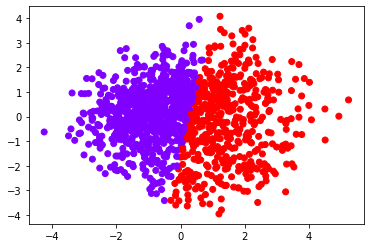

In [ ]:
#scale data and use pca to reduce dimenions
scalar = StandardScaler()
scaled_data = scalar.fit_transform(data)
pca = PCA(2)
pca.fit(scaled_data)
transformed_Data = pca.transform(scaled_data)
kmeans = KMeans(2)
clusters_ = kmeans.fit(pca.transform(scaled_data))
plt.scatter(transformed_Data[:,0], transformed_Data[:,1], c=kmeans.labels_, cmap='rainbow')

In [ ]:
from warnings import WarningMessage
'''
Repository of functions used in this notebook

general model function
'''
def print_train_scores(scores):
  print("Precision : ", np.mean(scores["train_precision"]))
  print("Recall    : ", np.mean(scores["train_recall"]))
  print("F1-score  : ", np.mean(scores["train_f1"]))
  print("Accuracy  : ", np.mean(scores["train_accuracy"]))


def print_test_scores(scores):
  print("Precision : ", np.mean(scores["test_precision"]))
  print("Recall    : ", np.mean(scores["test_recall"]))
  print("F1-score  : ", np.mean(scores["test_f1"]))
  print("Accuracy  : ", np.mean(scores["test_accuracy"]))


def model_build(data, target, model):

  #split data to train and test
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

  #fit the model
  reg = model.fit(X_train, y_train)
  scores = cross_validate(reg, X_train, y_train, cv=5, scoring=['precision','recall','accuracy','f1'], return_train_score=True)
  print("Cross validation scores")
  print("On train set:")
  print_train_scores(scores)

  print("On test set")
  print_test_scores(scores)

  #for test data print confusion matrix
  model_pred = reg.predict(X_test)
  print("Scores on test data")
  print("Roc Auc scores", roc_auc_score(y_test, model_pred))
  print("Confusion Matrix", confusion_matrix(y_test, model_pred))
  print(classification_report(y_test, model_pred))
  return reg

def save_model(model, path):
  #save model
  pickle.dump(rf, open(path, 'wb'))

#test for single inputs only
def load_predict(path, input):
  model_ = pickle.load(open(path, 'rb'))
  prediction = model_.predict(input, WarningMessage=False)
  # print("Prediction: {}".format(prediction))
  return model_, prediction

def random_search(data, target, est_, param_, n_iter = 100, cv = 3):
  clf = RandomizedSearchCV(estimator = est_, param_distributions = param_, n_iter = n_iter, cv = cv, verbose=2, random_state=42, n_jobs=-1)
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
  clf.fit(X_train, y_train)
  clf.best_params_
  return clf


##Logistic Regresssion
* Good baseline performace, nothing much to tune in LR
* No overfitting observed, can use better models to improve performance

* A noticable measure here is the decrease in FP compared to (https://www.kaggle.com/code/kairosart/machine-learning-for-mental-health-1/notebook). This can be attributed to the intelligent choice of metrics!

In [ ]:
clf = LogisticRegression(solver='liblinear', random_state=42, max_iter = 200)
lr = model_build(data, target, clf)

Cross validation scores
On train set:
Precision :  0.7175980754057018
Recall    :  0.7105874849408262
F1-score  :  0.7140041281899461
Accuracy  :  0.7095356256646579
On test set
Precision :  0.7107150953688002
Recall    :  0.7177803160098992
F1-score  :  0.7140196719139885
Accuracy  :  0.7061277769568002
Scores on test data
Roc Auc scores 0.6934203062960862
Confusion Matrix [[95 34]
 [43 80]]
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       129
           1       0.70      0.65      0.68       123

    accuracy                           0.69       252
   macro avg       0.70      0.69      0.69       252
weighted avg       0.69      0.69      0.69       252



##Random Forest
* The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).
* While other metrics remained almost the same, we see an improvement in the recall after random search CV


In [ ]:
#first run a basic random forest classifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
rf = model_build(data, target, clf)

Cross validation scores
On train set:
Precision :  0.7807381470582607
Recall    :  0.7937719982047102
F1-score  :  0.7870966542848739
Accuracy  :  0.7807891127105713
On test set
Precision :  0.7047062947318441
Recall    :  0.7333523700742434
F1-score  :  0.7184458771698382
Accuracy  :  0.7060982217624747
Scores on test data
Roc Auc scores 0.7150690111552278
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       129
           1       0.69      0.75      0.72       123

    accuracy                           0.71       252
   macro avg       0.72      0.72      0.71       252
weighted avg       0.72      0.71      0.71       252



In [ ]:
#Tune the classifier
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]   #no of trees in the forest
max_features = ['auto', 'sqrt']   # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]    # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]   # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]     # Minimum number of samples required at each leaf node
bootstrap = [True, False]     # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 14, 24, 33, 43, 52, 62, 71, 81, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 66, 83, 100, 116, 133, 150, 166, 183, 200]}


In [ ]:
rf_rscv = random_search(data, target, RandomForestClassifier(), random_grid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_rscv.best_params_

{'n_estimators': 183,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5,
 'bootstrap': False}

In [ ]:
clf = RandomForestClassifier(n_estimators = 166, min_samples_split = 5, min_samples_leaf = 1, max_features = 'auto', max_depth = 5,
 bootstrap= True, random_state=0)
rf = model_build(data, target, clf)

Cross validation scores
On train set:
Precision :  0.7681491406618426
Recall    :  0.7957161080008505
F1-score  :  0.781532514141981
Accuracy  :  0.7728375691629549
On test set
Precision :  0.7081414867999165
Recall    :  0.7391966495335999
F1-score  :  0.7223776946847268
Accuracy  :  0.7090832963893404
Scores on test data
Roc Auc scores 0.7146908678389109
Confusion Matrix [[90 39]
 [33 90]]
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       129
           1       0.70      0.73      0.71       123

    accuracy                           0.71       252
   macro avg       0.71      0.71      0.71       252
weighted avg       0.72      0.71      0.71       252



In [ ]:
clf1 = RandomForestClassifier(n_estimators = 183, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 5,
 bootstrap= False, random_state=0)
rf = model_build(data, target, clf1)

Cross validation scores
On train set:
Precision :  0.7677863616544587
Recall    :  0.7966893440105828
F1-score  :  0.781887939650104
Accuracy  :  0.7730890988394494
On test set
Precision :  0.6994802878854396
Recall    :  0.7411193603655055
F1-score  :  0.7190337217730642
Accuracy  :  0.7031377764642135
Scores on test data
Roc Auc scores 0.7030629608621668
Confusion Matrix [[87 42]
 [33 90]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       129
           1       0.68      0.73      0.71       123

    accuracy                           0.70       252
   macro avg       0.70      0.70      0.70       252
weighted avg       0.70      0.70      0.70       252



## Trying some ensemble methods

In [ ]:
#Bagging

#default base estimator is decision tree
clf_bagging = BaggingClassifier()
pprint(clf_bagging.get_params())

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
base_estimator = [SVC(), None]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]   
bootstrap_features = [True, False]     # Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'base_estimator':base_estimator,
              'n_estimators': n_estimators,
               'bootstrap_features': bootstrap_features,
               'bootstrap': bootstrap,
               }
pprint(random_grid)

{'base_estimator': [SVC(), None],
 'bootstrap': [True, False],
 'bootstrap_features': [True, False],
 'n_estimators': [50, 66, 83, 100, 116, 133, 150, 166, 183, 200]}


In [ ]:
clf_bagging_cv = random_search(data, target, clf_bagging, random_grid)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 80 candidates, totalling 240 fits


In [ ]:
clf_bagging_cv.best_params_

{'n_estimators': 116,
 'bootstrap_features': False,
 'bootstrap': True,
 'base_estimator': None}

In [ ]:
clf2 = model_build(data, target, BaggingClassifier(base_estimator = SVC(), n_estimators = 116, bootstrap= True, random_state=42))

Cross validation scores
On train set:
Precision :  0.5370443681082342
Recall    :  0.7937790848746842
F1-score  :  0.6406292532959275
Accuracy  :  0.5454343972997548
On test set
Precision :  0.5365481997364122
Recall    :  0.7957738435179897
F1-score  :  0.6406998134560378
Accuracy  :  0.5441997931136398
Scores on test data
Roc Auc scores 0.5702401210058612
Confusion Matrix [[ 37  92]
 [ 18 105]]
              precision    recall  f1-score   support

           0       0.67      0.29      0.40       129
           1       0.53      0.85      0.66       123

    accuracy                           0.56       252
   macro avg       0.60      0.57      0.53       252
weighted avg       0.60      0.56      0.53       252



In [ ]:
clf3 = model_build(data, target, BaggingClassifier(n_estimators = 116, bootstrap= True, random_state=42))

Cross validation scores
On train set:
Precision :  1.0
Recall    :  1.0
F1-score  :  1.0
Accuracy  :  1.0
On test set
Precision :  0.6839976961184335
Recall    :  0.6866171711403009
F1-score  :  0.6850070765944135
Accuracy  :  0.6782720063051081
Scores on test data
Roc Auc scores 0.6908678389109473
Confusion Matrix [[87 42]
 [36 87]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       129
           1       0.67      0.71      0.69       123

    accuracy                           0.69       252
   macro avg       0.69      0.69      0.69       252
weighted avg       0.69      0.69      0.69       252



In [ ]:
#boosting
# boost = AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=200)
boost = AdaBoostClassifier(rf, n_estimators=200)

In [ ]:
clf4 = model_build(data, target, boost)

Cross validation scores
On train set:
Precision :  1.0
Recall    :  1.0
F1-score  :  1.0
Accuracy  :  1.0
On test set
Precision :  0.6287214768948515
Recall    :  0.6263087759375595
F1-score  :  0.6266073976008459
Accuracy  :  0.6197034628836018
Scores on test data
Roc Auc scores 0.6548496880317641
Confusion Matrix [[84 45]
 [42 81]]
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       129
           1       0.64      0.66      0.65       123

    accuracy                           0.65       252
   macro avg       0.65      0.65      0.65       252
weighted avg       0.66      0.65      0.65       252



In [ ]:
# save_model(rf, '/content/drive/Shareddrives/Capstone Project/ML_DL_work/Models/rf_model.pkl')

sample_test = np.array([ [2,45,41,0,0,5,1,1,2,2,2,0,1,1,2,2,2,1] ])
saved_model, pre = load_predict('/content/drive/Shareddrives/Capstone Project/ML_DL_work/Models/rf_model.pkl', sample_test)
print(pre)

[1]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


## Feature importance
* We see that family_history, care_options, gender are the top 3 important features
* while self-employed, tech_company and remote work are the least important features



In [ ]:
for i in sorted(zip(rf.feature_names_in_, rf.feature_importances_), key=lambda x:x[1], reverse=True):
  print(i)

('family_history', 0.3377940624451065)
('care_options', 0.16572763079501976)
('Gender', 0.08412654567200836)
('state', 0.04865890180729713)
('leave', 0.04327435117956255)
('Country', 0.03708470502979647)
('age_range', 0.03630479835059651)
('mental_health_consequence', 0.03504135897777468)
('no_employees', 0.03429368298606865)
('mental_vs_physical', 0.033016076771037545)
('seek_help', 0.029174997108821012)
('wellness_program', 0.02495915854105602)
('coworkers', 0.020573650772066354)
('supervisor', 0.019592471932317966)
('phys_health_consequence', 0.014719787893461867)
('self_employed', 0.013266172650993476)
('remote_work', 0.012438069750660275)
('tech_company', 0.009953577336354835)


In [ ]:
rf.feature_names_in_

array(['Gender', 'Country', 'state', 'self_employed', 'family_history',
       'no_employees', 'remote_work', 'tech_company', 'care_options',
       'wellness_program', 'seek_help', 'leave',
       'mental_health_consequence', 'phys_health_consequence',
       'coworkers', 'supervisor', 'mental_vs_physical', 'age_range'],
      dtype=object)

In [ ]:
'''
references:
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


'''